#  Projet : Classification avec Arbres de Décision et Forêts Aléatoires
##  Dataset : Forest Covertypes
# 
# **Objectif** : Prédire le type de couverture forestière à partir de données cartographiques
# 
# **Auteurs** :
# Benabdessadek Dikra 
# Ouhmidou Amine
# Souleimani Mohamed Rayan
# El Fattahi Wissal
# **Date** : 1/12/2026
# 
#  Description du jeu de données
### Le dataset Forest Covertypes contient des observations de 7 types de couverture forestière
### dans la Roosevelt National Forest du Colorado.
# 
# **Variables** :
# - 10 variables quantitatives (élévation, pente, etc.)
# - 44 variables binaires (0/1) de type "wilderness area" et "soil type"
# - Variable cible : Cover_Type (1 à 7)
# 
# **Source** : UCI Machine Learning Repository


# 1. Installation et importation des bibliothèques

### Installation des bibliothèques si nécessaire

### Importation des bibliothèques:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# import scikitplot as skplt

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                           classification_report, roc_auc_score, roc_curve)
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
SEED = 42
np.random.seed(SEED)

### Configuration pour la reproductibilité

### Configuration de l'affichage


In [3]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

## 2. Chargement et exploration des données

### Chargement du dataset Forest Covertypes

In [4]:
print("Chargement du dataset Forest Covertypes...")
covtype = fetch_covtype()
X = covtype.data
y = covtype.target

print(f"Dimensions du dataset : {X.shape}")
print(f"Nombre d'échantillons : {X.shape[0]}")
print(f"Nombre de caractéristiques : {X.shape[1]}")
print(f"Classes uniques : {np.unique(y)}")
print(f"Nom des classes : {covtype.target_names}")



Chargement du dataset Forest Covertypes...
Dimensions du dataset : (581012, 54)
Nombre d'échantillons : 581012
Nombre de caractéristiques : 54
Classes uniques : [1 2 3 4 5 6 7]
Nom des classes : ['Cover_Type']


### Création d'un DataFrame pour l'exploration

In [5]:
feature_names = covtype.feature_names
df = pd.DataFrame(X, columns=feature_names)
df['Cover_Type'] = y

print("\n=== Aperçu des premières lignes ===")
print(df.head())

print("\n=== Informations sur les données ===")
print(df.info())



=== Aperçu des premières lignes ===
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     2596.0    51.0    3.0                             258.0   
1     2590.0    56.0    2.0                             212.0   
2     2804.0   139.0    9.0                             268.0   
3     2785.0   155.0   18.0                             242.0   
4     2595.0    45.0    2.0                             153.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                             0.0                            510.0   
1                            -6.0                            390.0   
2                            65.0                           3180.0   
3                           118.0                           3090.0   
4                            -1.0                            391.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0          221.0           232.0          148.0   
1          220.0           235.0          151.0  

### Distribution des classes


=== Distribution des classes ===
Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64


([<matplotlib.axis.XTick at 0x269886eb8c0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7')])

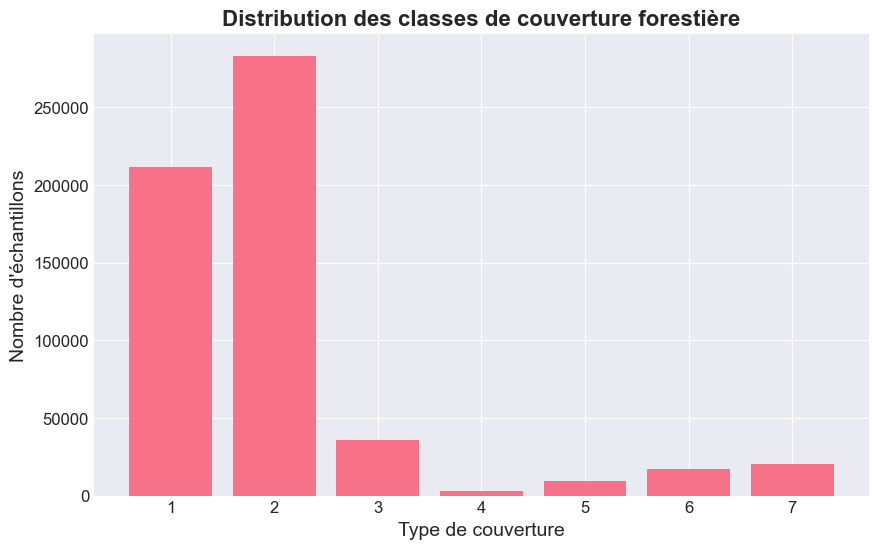

In [6]:
print("\n=== Distribution des classes ===")
class_distribution = df['Cover_Type'].value_counts().sort_index()
print(class_distribution)

plt.figure(figsize=(10, 6))
bars = plt.bar(class_distribution.index, class_distribution.values)
plt.title('Distribution des classes de couverture forestière', fontsize=16, fontweight='bold')
plt.xlabel('Type de couverture', fontsize=14)
plt.ylabel('Nombre d\'échantillons', fontsize=14)
plt.xticks(class_distribution.index)


### Ajout des valeurs sur les barres

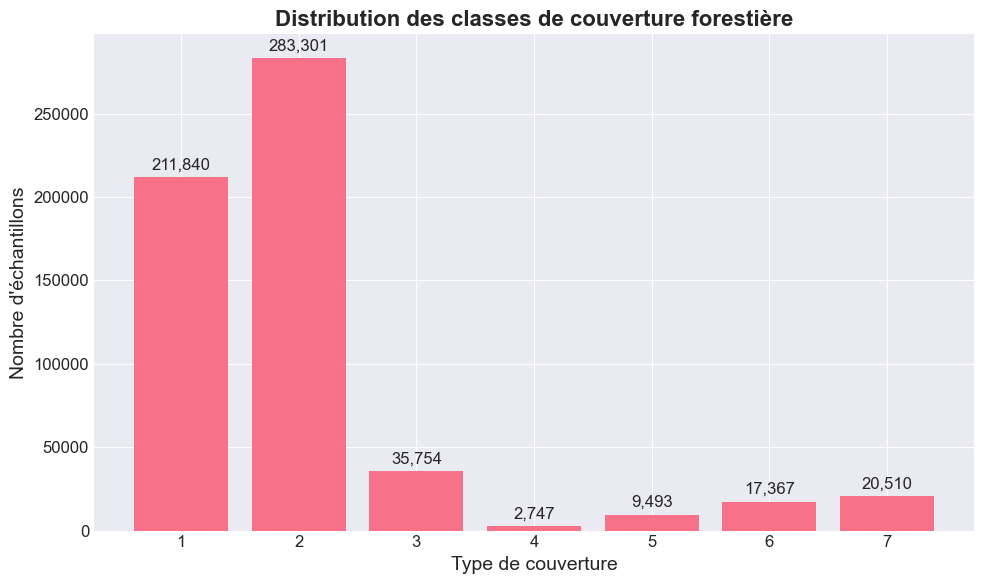

In [7]:
plt.figure(figsize=(10, 6))
bars = plt.bar(class_distribution.index, class_distribution.values)
plt.title('Distribution des classes de couverture forestière', fontsize=16, fontweight='bold')
plt.xlabel('Type de couverture', fontsize=14)
plt.ylabel('Nombre d\'échantillons', fontsize=14)
plt.xticks(class_distribution.index)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # position horizontale centrée
        height + max(class_distribution.values)*0.01,  # petit décalage au-dessus
        f'{int(height):,}',  # formatage avec séparateur de milliers
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


### Vérification des valeurs manquantes

In [8]:
print("\n=== Valeurs manquantes ===")
print(df.isnull().sum().sum(), "valeurs manquantes au total")


=== Valeurs manquantes ===
0 valeurs manquantes au total


### Statistiques descriptives

In [9]:
print("\n=== Statistiques descriptives ===")
print(df.describe())



=== Statistiques descriptives ===
           Elevation         Aspect          Slope  \
count  581012.000000  581012.000000  581012.000000   
mean     2959.365301     155.656807      14.103704   
std       279.984734     111.913721       7.488242   
min      1859.000000       0.000000       0.000000   
25%      2809.000000      58.000000       9.000000   
50%      2996.000000     127.000000      13.000000   
75%      3163.000000     260.000000      18.000000   
max      3858.000000     360.000000      66.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     581012.000000                   581012.000000   
mean                         269.428217                       46.418855   
std                          212.549356                       58.295232   
min                            0.000000                     -173.000000   
25%                          108.000000                        7.000000   
50%                         

### Analyse des corrélations (premières 10 caractéristiques)

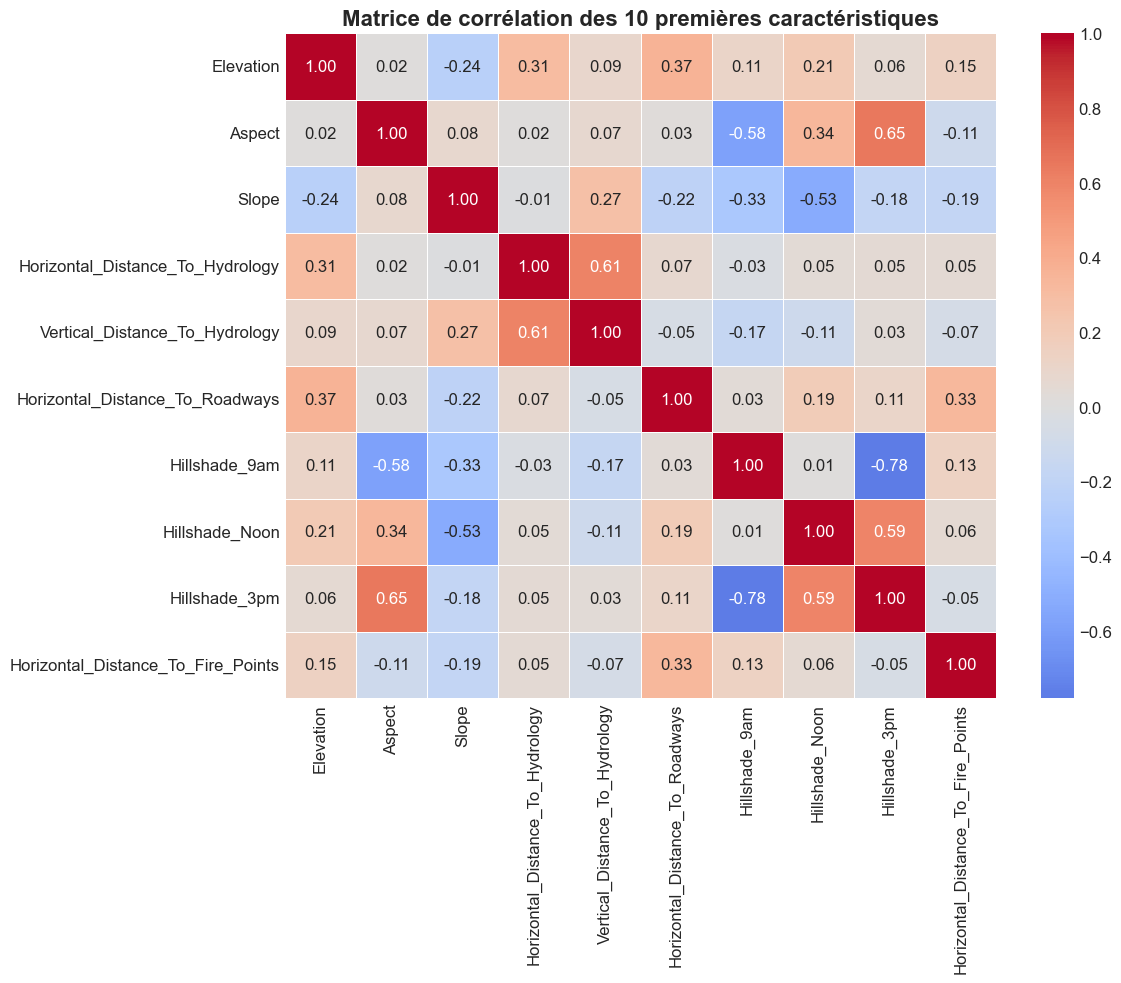

In [10]:
plt.figure(figsize=(12, 10))
corr_matrix = df.iloc[:, :10].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation des 10 premières caractéristiques', 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## 3. Prétraitement des données
### Séparation des caractéristiques numériques et catégorielles binaires
### Les 10 premières caractéristiques sont numériques, les autres sont binaires


In [11]:
numerical_features = feature_names[:10]
binary_features = feature_names[10:]

print(f"Caractéristiques numériques ({len(numerical_features)}) :")
print(numerical_features)

print(f"\nCaractéristiques binaires ({len(binary_features)}) :")
print(binary_features[:5], "...")

Caractéristiques numériques (10) :
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

Caractéristiques binaires (44) :
['Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0'] ...


### Normalisation des caractéristiques numériques


In [12]:
scaler = StandardScaler()
X_numerical = X[:, :10]
X_numerical_scaled = scaler.fit_transform(X_numerical)


### Les caractéristiques binaires ne nécessitent pas de normalisation


In [13]:
X_binary = X[:, 10:]


### Concaténation des caractéristiques


In [14]:
X_processed = np.hstack([X_numerical_scaled, X_binary])

print("Dimensions après prétraitement :", X_processed.shape)


Dimensions après prétraitement : (581012, 54)


### Encodage de la variable cible (déjà encodée de 1 à 7)
### Conversion en format 0-6 pour scikit-learn

In [15]:
y_processed = y - 1
print("Classes après encodage :", np.unique(y_processed))

Classes après encodage : [0 1 2 3 4 5 6]


## 4. Séparation des données et modèle baseline


### Séparation train/test (80/20)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, 
    test_size=0.2, 
    random_state=SEED,
    stratify=y_processed  
)

print(f"Train set : {X_train.shape[0]} échantillons")
print(f"Test set  : {X_test.shape[0]} échantillons")


Train set : 464809 échantillons
Test set  : 116203 échantillons


### Modèle baseline : Classifier le plus fréquent


In [17]:
print("\n=== Modèle Baseline (Dummy Classifier) ===")
baseline = DummyClassifier(strategy='most_frequent', random_state=SEED)
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_test)


=== Modèle Baseline (Dummy Classifier) ===


### Évaluation


In [18]:
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline, average='weighted')

print(f"Accuracy baseline : {accuracy_baseline:.4f}")
print(f"F1-score baseline : {f1_baseline:.4f}")


Accuracy baseline : 0.4876
F1-score baseline : 0.3197


### Matrice de confusion


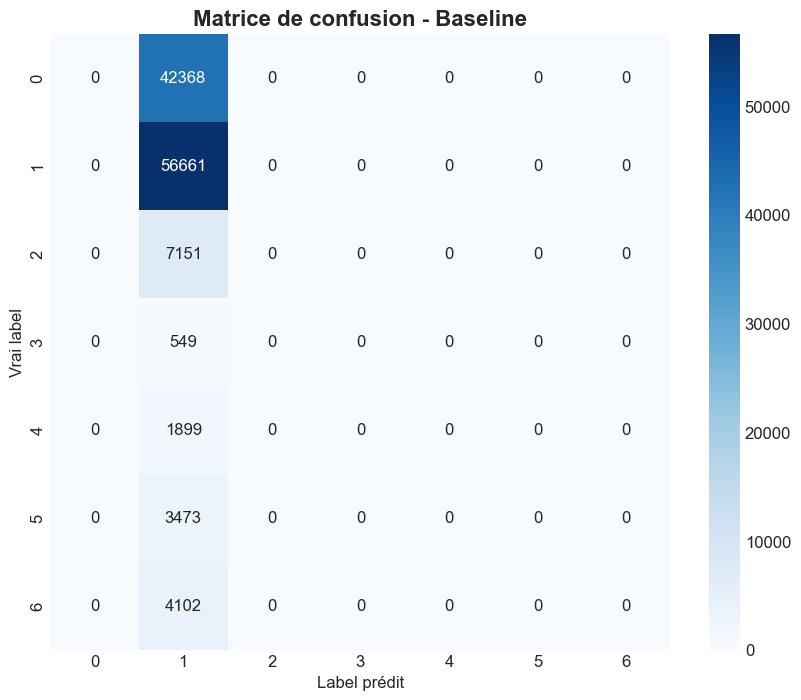

In [19]:
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion - Baseline', fontsize=16, fontweight='bold')
plt.ylabel('Vrai label')
plt.xlabel('Label prédit')
plt.show()


## 5. Arbre de Décision (Classification)


### Entraînement d'un arbre de décision avec paramètres par défaut


In [20]:
print("\n=== Arbre de Décision (paramètres par défaut) ===")
dt_default = DecisionTreeClassifier(random_state=SEED)
dt_default.fit(X_train, y_train)


=== Arbre de Décision (paramètres par défaut) ===


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### Prédictions


In [21]:
y_pred_dt_default = dt_default.predict(X_test)


### Évaluation


In [22]:
accuracy_dt_default = accuracy_score(y_test, y_pred_dt_default)
f1_dt_default = f1_score(y_test, y_pred_dt_default, average='weighted')

print(f"Accuracy (arbre par défaut) : {accuracy_dt_default:.4f}")
print(f"F1-score (arbre par défaut) : {f1_dt_default:.4f}")

Accuracy (arbre par défaut) : 0.9389
F1-score (arbre par défaut) : 0.9389


### Visualisation de l'arbre (version simplifiée)


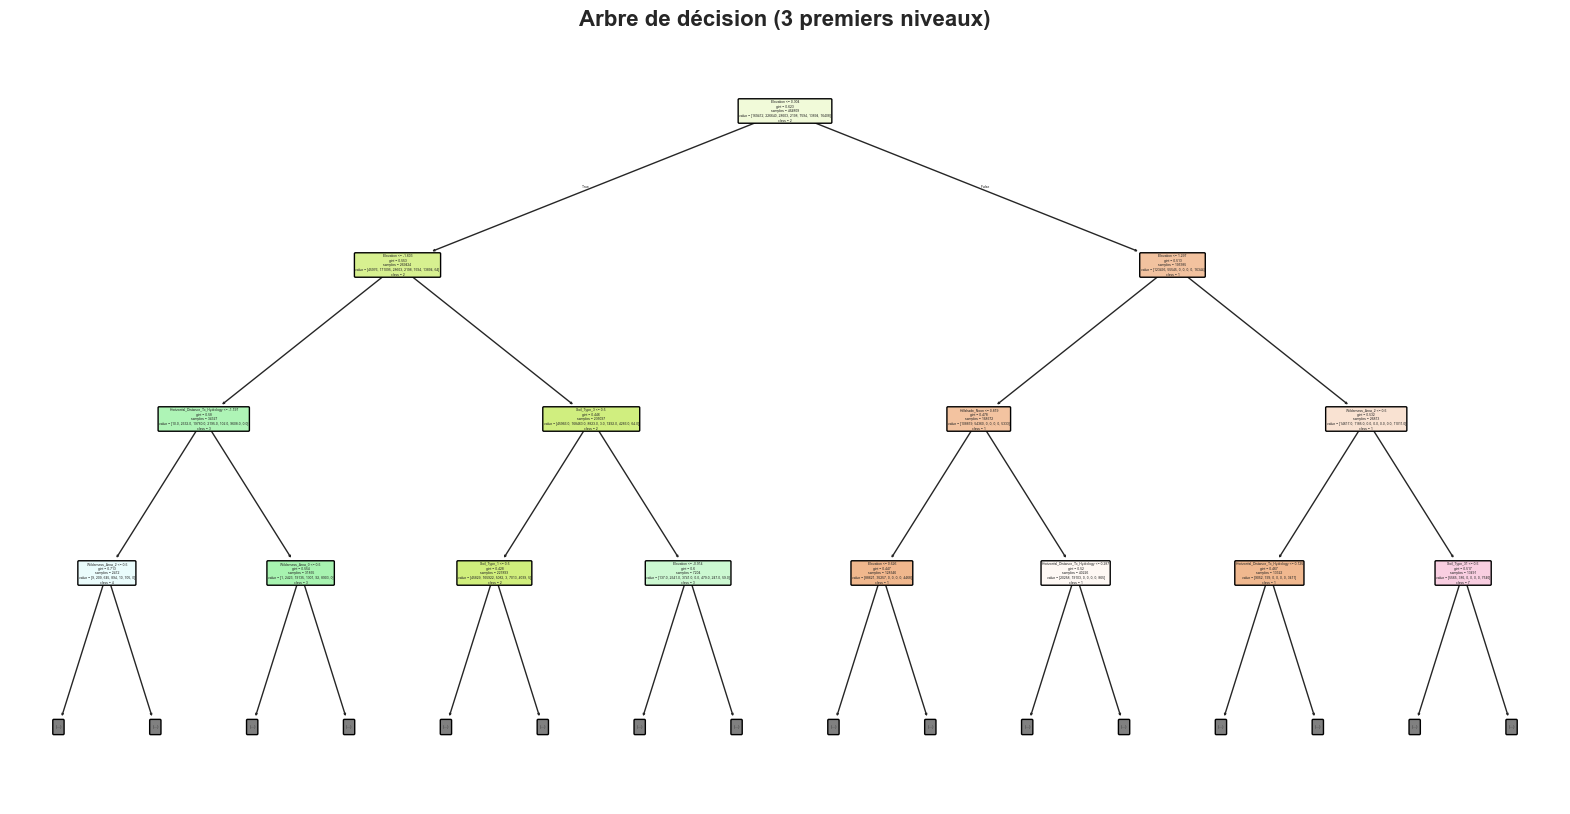

In [23]:
plt.figure(figsize=(20, 10))
plot_tree(dt_default, max_depth=3, feature_names=feature_names, 
          class_names=[str(i) for i in range(1, 8)], 
          filled=True, rounded=True)
plt.title("Arbre de décision (3 premiers niveaux)", fontsize=16, fontweight='bold')
plt.show()


### Importance des caractéristiques


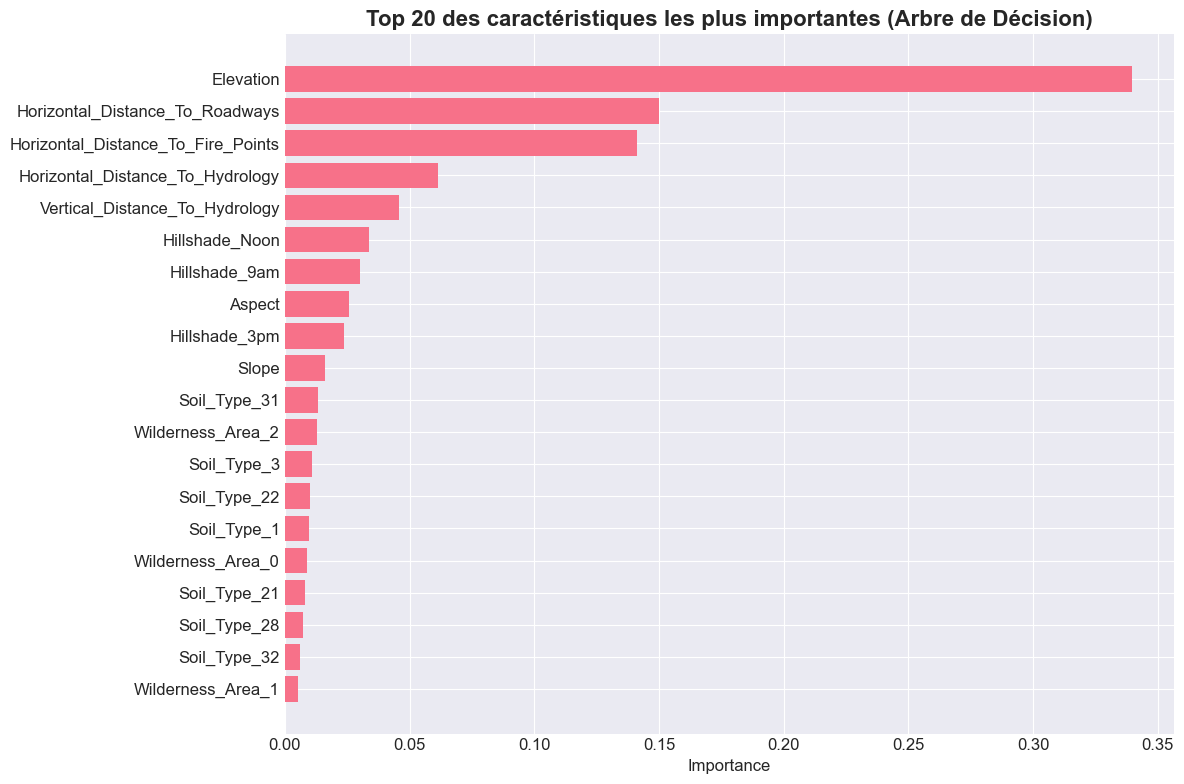

In [24]:
importances = dt_default.feature_importances_
indices = np.argsort(importances)[::-1][:20]  # Top 20 caractéristiques

plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices[::-1]])
plt.xlabel('Importance')
plt.title('Top 20 des caractéristiques les plus importantes (Arbre de Décision)', 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Recherche d'hyperparamètres pour l'Arbre de Décision

### Validation croisée pour trouver les meilleurs hyperparamètres


In [25]:
print("\n=== Recherche d'hyperparamètres (Arbre de Décision) ===")
param_grid_dt = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}


=== Recherche d'hyperparamètres (Arbre de Décision) ===


### Recherche par validation croisée (k=5)


In [26]:
dt = DecisionTreeClassifier(random_state=SEED)
grid_search_dt = GridSearchCV(
    dt, param_grid_dt, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_dt.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid_search_dt.best_params_}")
print(f"Meilleur score (validation croisée) : {grid_search_dt.best_score_:.4f}")


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Meilleurs paramètres : {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Meilleur score (validation croisée) : 0.9379


### Évaluation du meilleur modèle


In [27]:
dt_best = grid_search_dt.best_estimator_
y_pred_dt_best = dt_best.predict(X_test)

accuracy_dt_best = accuracy_score(y_test, y_pred_dt_best)
f1_dt_best = f1_score(y_test, y_pred_dt_best, average='weighted')

print(f"Accuracy (meilleur arbre) : {accuracy_dt_best:.4f}")
print(f"F1-score (meilleur arbre) : {f1_dt_best:.4f}")

Accuracy (meilleur arbre) : 0.9437
F1-score (meilleur arbre) : 0.9436


### Matrice de confusion


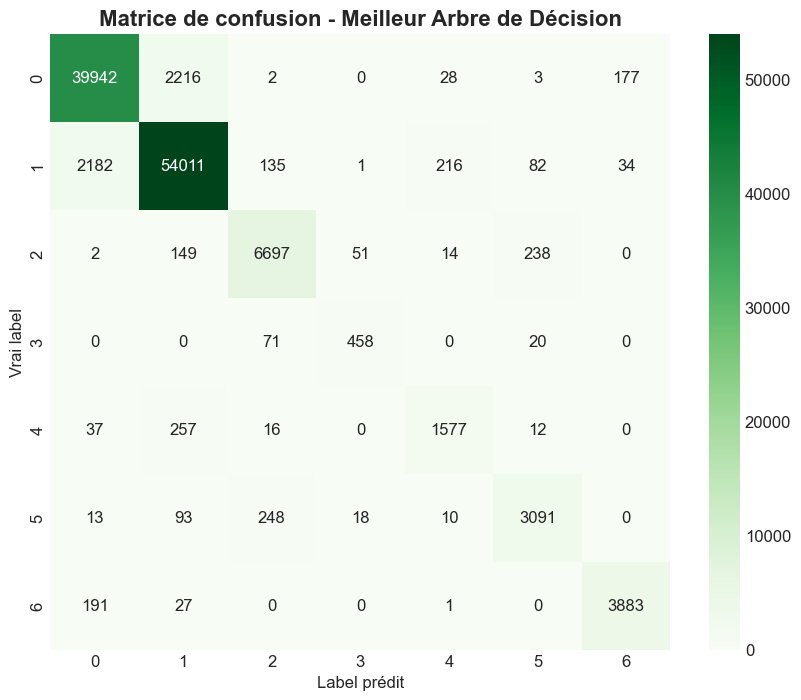

In [28]:
cm_dt = confusion_matrix(y_test, y_pred_dt_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens')
plt.title('Matrice de confusion - Meilleur Arbre de Décision', 
          fontsize=16, fontweight='bold')
plt.ylabel('Vrai label')
plt.xlabel('Label prédit')
plt.show()


## 7. Forêt Aléatoire (Random Forest)


### Entraînement d'une forêt aléatoire avec paramètres par défaut


In [29]:
print("\n=== Forêt Aléatoire (paramètres par défaut) ===")
rf_default = RandomForestClassifier(random_state=SEED, n_jobs=-1)
rf_default.fit(X_train, y_train)

y_pred_rf_default = rf_default.predict(X_test)

accuracy_rf_default = accuracy_score(y_test, y_pred_rf_default)
f1_rf_default = f1_score(y_test, y_pred_rf_default, average='weighted')

print(f"Accuracy (forêt par défaut) : {accuracy_rf_default:.4f}")
print(f"F1-score (forêt par défaut) : {f1_rf_default:.4f}")



=== Forêt Aléatoire (paramètres par défaut) ===
Accuracy (forêt par défaut) : 0.9532
F1-score (forêt par défaut) : 0.9530


### Importance des caractéristiques pour Random Forest

In [ ]:
importances_rf = rf_default.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1][:20]

plt.figure(figsize=(12, 8))
plt.barh(range(len(indices_rf)), importances_rf[indices_rf][::-1])
plt.yticks(range(len(indices_rf)), [feature_names[i] for i in indices_rf[::-1]])
plt.xlabel('Importance')
plt.title('Top 20 des caractéristiques les plus importantes (Random Forest)', 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Recherche d'hyperparamètres pour Random Forest

### Recherche d'hyperparamètres avec RandomizedSearchCV (plus rapide)


In [31]:
print("\n=== Recherche d'hyperparamètres (Random Forest) ===")

param_dist_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=SEED, n_jobs=-1)
random_search_rf = RandomizedSearchCV(
    rf, param_dist_rf,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

random_search_rf.fit(X_train, y_train)

print(f"Meilleurs paramètres : {random_search_rf.best_params_}")
print(f"Meilleur score (validation croisée) : {random_search_rf.best_score_:.4f}")



Meilleurs paramètres : {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
Meilleur score (validation croisée) : 0.9524


### Évaluation du meilleur modèle Random Forest


In [32]:
rf_best = random_search_rf.best_estimator_
y_pred_rf_best = rf_best.predict(X_test)

accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)
f1_rf_best = f1_score(y_test, y_pred_rf_best, average='weighted')

print(f"Accuracy (meilleure forêt) : {accuracy_rf_best:.4f}")
print(f"F1-score (meilleure forêt) : {f1_rf_best:.4f}")


Accuracy (meilleure forêt) : 0.9595
F1-score (meilleure forêt) : 0.9593


### Matrice de confusion


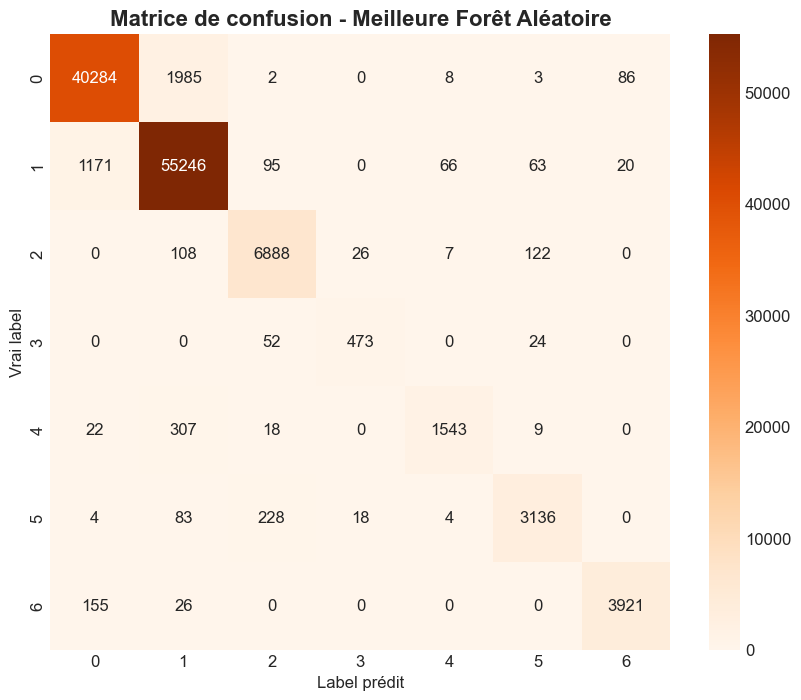

In [33]:
cm_rf = confusion_matrix(y_test, y_pred_rf_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges')
plt.title('Matrice de confusion - Meilleure Forêt Aléatoire', 
          fontsize=16, fontweight='bold')
plt.ylabel('Vrai label')
plt.xlabel('Label prédit')
plt.show()


## 9. Comparaison des modèles


### Tableau récapitulatif des performances


In [34]:
results = pd.DataFrame({
    'Modèle': ['Baseline', 'Arbre (défaut)', 'Arbre (optimisé)', 
               'Forêt (défaut)', 'Forêt (optimisée)'],
    'Accuracy': [accuracy_baseline, accuracy_dt_default, accuracy_dt_best,
                 accuracy_rf_default, accuracy_rf_best],
    'F1-score': [f1_baseline, f1_dt_default, f1_dt_best,
                 f1_rf_default, f1_rf_best]
})

print("=== Comparaison des modèles ===")
print(results.to_string(index=False))


=== Comparaison des modèles ===
           Modèle  Accuracy  F1-score
         Baseline  0.487604  0.319651
   Arbre (défaut)  0.938909  0.938904
 Arbre (optimisé)  0.943685  0.943645
   Forêt (défaut)  0.953246  0.953004
Forêt (optimisée)  0.959450  0.959295


### Visualisation comparative


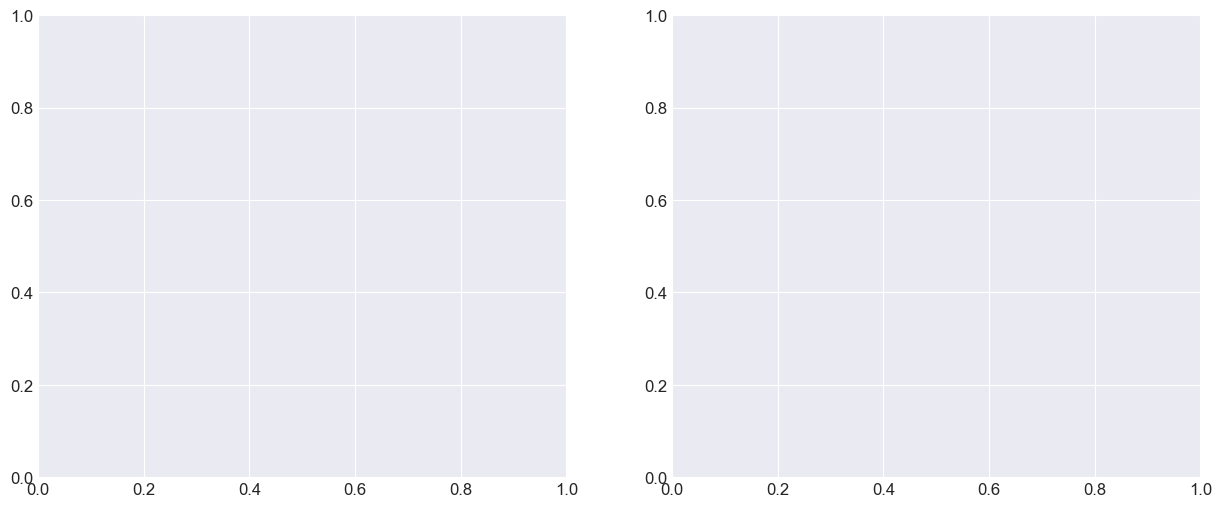

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))


### Accuracy


In [36]:
axes[0].bar(results['Modèle'], results['Accuracy'], color=['gray', 'blue', 'green', 'orange', 'red'])
axes[0].set_title('Comparaison des Accuracies', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim([0, 1])

(0.0, 1.0)

### Ajout des valeurs


In [37]:
for i, v in enumerate(results['Accuracy']):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

### F1-score


In [38]:
axes[1].bar(results['Modèle'], results['F1-score'], color=['gray', 'blue', 'green', 'orange', 'red'])
axes[1].set_title('Comparaison des F1-scores', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1-score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim([0, 1])

(0.0, 1.0)

### Ajout des valeurs


In [39]:
for i, v in enumerate(results['F1-score']):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

## 10. Analyse des erreurs et interprétation


### Analyse des prédictions incorrectes pour le meilleur modèle


In [40]:
incorrect_indices = np.where(y_pred_rf_best != y_test)[0]
incorrect_samples = len(incorrect_indices)
total_samples = len(y_test)

print(f"\n=== Analyse des erreurs (Random Forest optimisé) ===")
print(f"Nombre total d'erreurs : {incorrect_samples}/{total_samples} ({incorrect_samples/total_samples*100:.2f}%)")



=== Analyse des erreurs (Random Forest optimisé) ===
Nombre total d'erreurs : 4712/116203 (4.05%)


### Distribution des classes dans les erreurs


In [41]:
incorrect_classes = y_test[incorrect_indices]
incorrect_predictions = y_pred_rf_best[incorrect_indices]

error_analysis = pd.DataFrame({
    'Vraie classe': incorrect_classes + 1,  # Reconversion en 1-7
    'Prédiction': incorrect_predictions + 1
})

print("\nExemples d'erreurs :")
print(error_analysis.head(10))




Exemples d'erreurs :
   Vraie classe  Prédiction
0             2           3
1             6           3
2             4           3
3             5           2
4             2           1
5             6           3
6             1           2
7             1           2
8             2           1
9             1           2


### Matrice de confusion normalisée


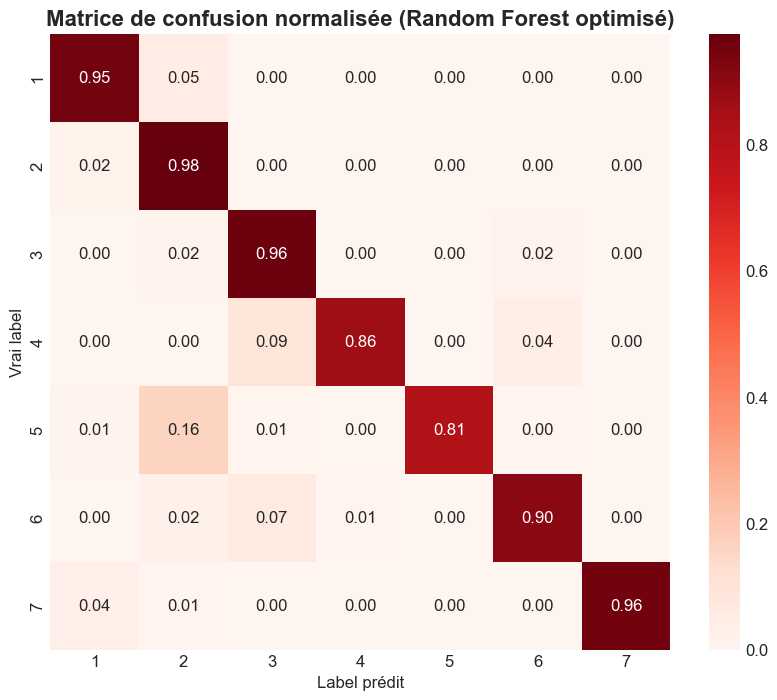

In [42]:
cm_normalized = confusion_matrix(y_test, y_pred_rf_best, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Reds', 
            xticklabels=range(1, 8), yticklabels=range(1, 8))
plt.title('Matrice de confusion normalisée (Random Forest optimisé)', 
          fontsize=16, fontweight='bold')
plt.ylabel('Vrai label')
plt.xlabel('Label prédit')
plt.show()


### Rapport de classification détaillé


In [43]:
print("\n=== Rapport de classification (Random Forest optimisé) ===")
print(classification_report(y_test, y_pred_rf_best, 
                           target_names=[f'Classe {i}' for i in range(1, 8)]))



=== Rapport de classification (Random Forest optimisé) ===
              precision    recall  f1-score   support

    Classe 1       0.97      0.95      0.96     42368
    Classe 2       0.96      0.98      0.97     56661
    Classe 3       0.95      0.96      0.95      7151
    Classe 4       0.91      0.86      0.89       549
    Classe 5       0.95      0.81      0.87      1899
    Classe 6       0.93      0.90      0.92      3473
    Classe 7       0.97      0.96      0.96      4102

    accuracy                           0.96    116203
   macro avg       0.95      0.92      0.93    116203
weighted avg       0.96      0.96      0.96    116203



## 11. Visualisation des données avec PCA


### Utilisation des 10 premières caractéristiques (les plus importantes)

In [44]:
print("\n=== Visualisation PCA ===")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed[:5000, :10])  # Sous-échantillon pour la visualisation
y_pca = y_processed[:5000]

print(f"Variance expliquée : {pca.explained_variance_ratio_}")



=== Visualisation PCA ===
Variance expliquée : [0.35790252 0.26786868]


### Visualisation


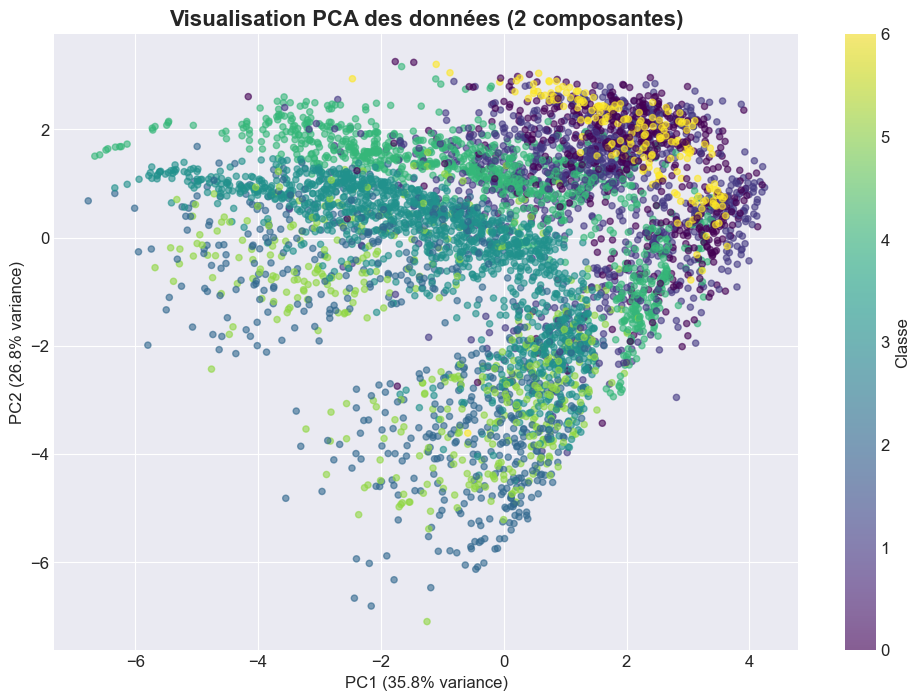

In [45]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pca, 
                     cmap='viridis', alpha=0.6, s=20)
plt.colorbar(scatter, label='Classe')
plt.title('Visualisation PCA des données (2 composantes)', 
          fontsize=16, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.show()

## 12. Limites et améliorations possibles

### Section d'analyse des limites


In [46]:
print("\n" + "="*60)
print("ANALYSE DES LIMITES ET AMÉLIORATIONS POSSIBLES")
print("="*60)

print("""
LIMITES IDENTIFIÉES :

1. **Données déséquilibrées** :
   - Certaines classes sont sous-représentées
   - Impact sur les performances pour les classes minoritaires

2. **Complexité des modèles** :
   - Les arbres profonds peuvent surapprendre
   - Les forêts aléatoires sont coûteuses en calcul

3. **Interprétabilité** :
   - Les forêts aléatoires sont moins interprétables que les arbres simples
   - Nombre élevé de caractéristiques (54) rend l'analyse difficile

4. **Temps d'entraînement** :
   - La recherche d'hyperparamètres est coûteuse
   - Le dataset est volumineux (581,012 échantillons)

AMÉLIORATIONS POSSIBLES :

1. **Gestion du déséquilibre** :
   - Utilisation de techniques de ré-échantillonnage (SMOTE, ADASYN)
   - Poids de classe dans les modèles

2. **Sélection de caractéristiques** :
   - Réduction de dimensionnalité (PCA, t-SNE)
   - Élimination des caractéristiques peu importantes

3. **Autres modèles** :
   - Test de Gradient Boosting (XGBoost, LightGBM)
   - Essai de réseaux de neurones simples

4. **Ingénierie des caractéristiques** :
   - Création de nouvelles caractéristiques
   - Regroupement des types de sol similaires

5. **Validation plus rigoureuse** :
   - Validation croisée stratifiée
   - Séparation temporelle si applicable
""")


ANALYSE DES LIMITES ET AMÉLIORATIONS POSSIBLES

LIMITES IDENTIFIÉES :

1. **Données déséquilibrées** :
   - Certaines classes sont sous-représentées
   - Impact sur les performances pour les classes minoritaires

2. **Complexité des modèles** :
   - Les arbres profonds peuvent surapprendre
   - Les forêts aléatoires sont coûteuses en calcul

3. **Interprétabilité** :
   - Les forêts aléatoires sont moins interprétables que les arbres simples
   - Nombre élevé de caractéristiques (54) rend l'analyse difficile

4. **Temps d'entraînement** :
   - La recherche d'hyperparamètres est coûteuse
   - Le dataset est volumineux (581,012 échantillons)

AMÉLIORATIONS POSSIBLES :

1. **Gestion du déséquilibre** :
   - Utilisation de techniques de ré-échantillonnage (SMOTE, ADASYN)
   - Poids de classe dans les modèles

2. **Sélection de caractéristiques** :
   - Réduction de dimensionnalité (PCA, t-SNE)
   - Élimination des caractéristiques peu importantes

3. **Autres modèles** :
   - Test de Grad

## 13. Conclusion

### Résumé final


In [47]:
print("\n" + "="*60)
print("CONCLUSION DU PROJET")
print("="*60)

print(f"""
RÉSULTATS PRINCIPAUX :

1. **Performance baseline** : {accuracy_baseline:.4f}
   - Modèle naïf prédit toujours la classe majoritaire

2. **Arbre de décision optimisé** : {accuracy_dt_best:.4f}
   - Amélioration significative par rapport au baseline
   - Interprétable mais risque de surapprentissage

3. **Forêt aléatoire optimisée** : {accuracy_rf_best:.4f}
   - Meilleure performance globale ({accuracy_rf_best - accuracy_baseline:.4f} d'amélioration)
   - Plus robuste mais moins interprétable

RECOMMANDATIONS :

1. **Pour l'interprétabilité** : Utiliser l'arbre de décision avec une profondeur limitée
2. **Pour la performance** : Privilégier la forêt aléatoire avec les hyperparamètres optimisés
3. **Pour la production** : Implémenter la forêt aléatoire avec monitoring régulier

PERSPECTIVES :

- Traiter le déséquilibre des classes pour améliorer les performances sur les classes minoritaires
- Explorer d'autres algorithmes d'ensemble comme le Gradient Boosting
- Développer une interface de prédiction pour les utilisateurs finaux
""")



CONCLUSION DU PROJET

RÉSULTATS PRINCIPAUX :

1. **Performance baseline** : 0.4876
   - Modèle naïf prédit toujours la classe majoritaire

2. **Arbre de décision optimisé** : 0.9437
   - Amélioration significative par rapport au baseline
   - Interprétable mais risque de surapprentissage

3. **Forêt aléatoire optimisée** : 0.9595
   - Meilleure performance globale (0.4718 d'amélioration)
   - Plus robuste mais moins interprétable

RECOMMANDATIONS :

1. **Pour l'interprétabilité** : Utiliser l'arbre de décision avec une profondeur limitée
2. **Pour la performance** : Privilégier la forêt aléatoire avec les hyperparamètres optimisés
3. **Pour la production** : Implémenter la forêt aléatoire avec monitoring régulier

PERSPECTIVES :

- Traiter le déséquilibre des classes pour améliorer les performances sur les classes minoritaires
- Explorer d'autres algorithmes d'ensemble comme le Gradient Boosting
- Développer une interface de prédiction pour les utilisateurs finaux



## Sauvegarde des modèles (optionnel)

In [48]:
import joblib
import os



## Création du dossier models s'il n'existe pas

In [49]:
os.makedirs('models', exist_ok=True)


## Sauvegarde des modèles


In [50]:
joblib.dump(dt_best, 'models/best_decision_tree.pkl')
joblib.dump(rf_best, 'models/best_random_forest.pkl')
joblib.dump(scaler, 'models/scaler.pkl')

print("\nModèles sauvegardés dans le dossier 'models/'")
print("- best_decision_tree.pkl")
print("- best_random_forest.pkl")
print("- scaler.pkl")


Modèles sauvegardés dans le dossier 'models/'
- best_decision_tree.pkl
- best_random_forest.pkl
- scaler.pkl


## Version des bibliothèques pour reproductibilité


In [51]:
import sklearn
import sys

print("\n=== Versions des bibliothèques ===")
print(f"Python : {sys.version}")
print(f"Scikit-learn : {sklearn.__version__}")
print(f"NumPy : {np.__version__}")
print(f"Pandas : {pd.__version__}")


=== Versions des bibliothèques ===
Python : 3.13.9 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 19:09:58) [MSC v.1929 64 bit (AMD64)]
Scikit-learn : 1.7.2
NumPy : 2.3.5
Pandas : 2.3.3
